In [1]:
import numpy as np
import pandas as pd

# Loading MLflow libraries
import mlflow
from mlflow.models.signature import infer_signature
from lightgbm import LGBMClassifier

# Loading packages for building a Machine Learning pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Loading libraries for visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as display
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.automl import TuneHyperparameters
from synapse.ml.train import ComputeModelStatistics
from synapse.ml.predict import MLFlowTransformer
import lightgbm as lgb

from synapse.ml.train import TrainClassifier
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)

from synapse.ml.automl import *

print("All Modules Loaded")

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 3, Finished, Available)

All Modules Loaded


In [2]:
df = spark.sql("SELECT * FROM lakehousebronze.fraud_final")

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 4, Finished, Available)

In [3]:
EXPERIMENT_NAME = "frauddetection"
MODEL_NAME = "fraudmodel"
TARGET_COL = "label"

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 5, Finished, Available)

In [4]:
df_clean = df[[
'label'                                     ,
'txDayOfWeek'                                  ,
'transactionAmountUSD'                         ,
'digitalItemCount'                             ,
'physicalItemCount'                            ,
'accountAge'                                   ,
'paymentInstrumentAgeInAccount'                ,
'numPaymentRejects1dPerUser'                   ,
'accountCountryRisk'                           ,
'accountPostalCodeRisk'                        ,
'accountStateRisk'                             ,
'browserLanguageRisk'                          ,
'ipCountryCodeRisk'                            ,
'ipPostCodeRisk'                               ,
'ipStateRisk'                                  ,
'localHourRisk'                                ,
'paymentBillingCountryCodeRisk'                ,
'paymentBillingPostalCodeRisk'                 ,
'paymentBillingStateRisk'                      ,
'transactionCurrencyCodeRisk'                  ,
'isProxyIP'                                     ,
'paymentInstrumentType'                         ,
'cardType'                                      ,
'isUserRegistered'                              ,
'isHighAmount'                                  ,
'acctBillingAddressMismatchFlag'                ,
'acctBillingPostalCodeMismatchFlag'             ,
'acctBillingCountryMismatchFlag'                ,
'acctBillingNameMismatchFlag'                   ,
'acctShippingAddressMismatchFlag'               ,
'shippingBillingAddressMismatchFlag'          ,
'sumPurchaseCount1dPerUser',
'sumPurchaseAmount1dPerUser',
'sumPurchaseCount30dPerUser',
'sumPurchaseAmount30dPerUser' ]]

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 6, Finished, Available)

In [5]:
pdf = df_clean.toPandas()
X= pd.get_dummies(pdf.drop(['label'],axis=1),drop_first=True, dtype='int64')
y= pdf['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 7, Finished, Available)

In [6]:
lgb_model = LGBMClassifier(   
bagging_fraction=1.0, bagging_freq=7, 
boosting_type='gbdt',
colsample_bytree=1.0, feature_fraction=0.4, 
importance_type='split', learning_rate=0.05, 
min_child_samples=71, isUnbalance=True,
)

lgb_model

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 8, Finished, Available)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=7, feature_fraction=0.4,
               isUnbalance=True, learning_rate=0.05, min_child_samples=71)

In [7]:
print(f"\n\nTraining using the train dataset Started:\n")
fraud_model = lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        lgb.log_evaluation(10),
    ],
)

StatementMeta(, d6eda59b-16c1-41d9-8d9c-8fd4356a3d34, 9, Submitted, Running)



Training using the train dataset Started:



StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 11, Finished, Available)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

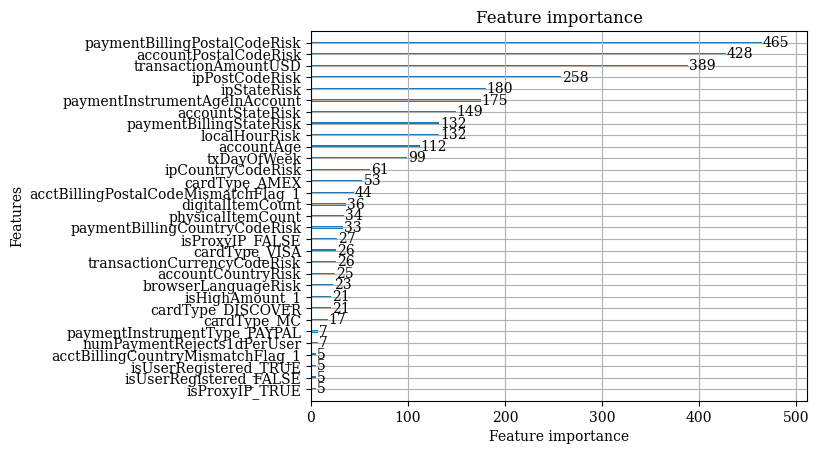

In [9]:
lgb.plot_importance(fraud_model)

In [10]:
TARGET_COL = "label"
feature_cols = [c for c in X_test.columns.tolist() if c not in [TARGET_COL]]

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 12, Finished, Available)

In [11]:
def prediction_to_spark(model, test):
    feature_cols = [c for c in test.columns.tolist() if c not in [TARGET_COL]]
    predictions = model.predict(test[feature_cols], num_iteration=model.best_iteration_)
    predictions = tuple(zip(test[TARGET_COL].tolist(), predictions.tolist()))
    dataColumns = [TARGET_COL, "prediction"]
    predictions = (
        spark.createDataFrame(data=predictions, schema=dataColumns)
        .withColumn(TARGET_COL, col(TARGET_COL).cast(IntegerType()))
        .withColumn("prediction", col("prediction").cast(DoubleType()))
    )

    return predictions

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 13, Finished, Available)

In [12]:
train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)
processed_df = pd.concat([train,test])

pred = prediction_to_spark(fraud_model, processed_df)
predictions = pred.toPandas()
predictions = predictions.drop(['label'],axis=1)
new_df = pd.concat([pdf,predictions],axis=1)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 14, Finished, Available)

[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


2024-01-14:21:21:14,91 WARNING  [tracking_store.py:153] log_inputs not supported


In [13]:
metrics = ComputeModelStatistics(
    evaluationMetric="classification", labelCol=TARGET_COL, scoredLabelsCol="prediction"
).transform(pred)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 15, Finished, Available)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 16, Finished, Available)

[[1.98286e+05 4.00000e+01]
 [5.94000e+02 5.75000e+02]]


Text(41.25, 0.5, 'True label')

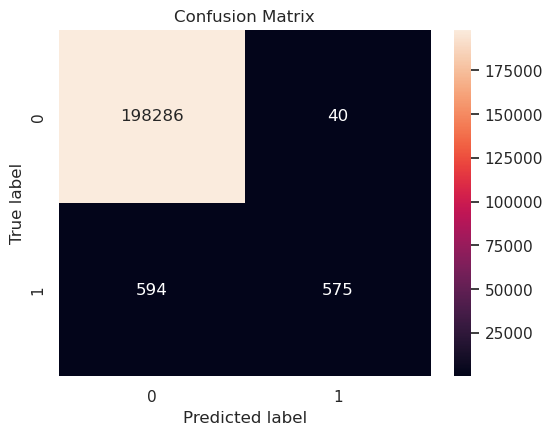

In [14]:
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)
sns.set(rc={"figure.figsize": (6, 4.5)})
ax = sns.heatmap(cm, annot=True, fmt=".20g")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [15]:
def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """
    # initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="prediction", labelCol=TARGET_COL)
    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"AUROC: {auroc:.4f}")
    
    # calculate AUPRC, baseline positive rate (0.172% in the demo data)
    auprc = _evaluator("areaUnderPR")
    print(f"AUPRC: {auprc:.4f}")
    return auroc, auprc

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 17, Finished, Available)

In [16]:
auroc, auprc = evaluate(pred)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 18, Finished, Available)

AUROC: 0.7458
AUPRC: 0.6989


In [17]:
signature = infer_signature(
    X_test,
    np.array(
        fraud_model.predict(X_test, num_iteration=fraud_model.best_iteration_),
        dtype="int_",
    ),
)

mlflow.set_experiment(EXPERIMENT_NAME)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 19, Finished, Available)

[LightGBM] [Warning] Unknown parameter: isUnbalance
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


2024-01-14:21:22:05,188 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


<Experiment: artifact_location='', creation_time=1705198890201, experiment_id='fc505efc-7b94-41c9-b02d-553936e01bbe', last_update_time=None, lifecycle_stage='active', name='frauddetection', tags={}>

In [18]:
# log model, metrics and params
raw_model_info = [fraud_model, auprc, auroc]
data_enhancements = ["None", "SMOTE"]
for idx, info in enumerate([raw_model_info]):
    model, auprc, auroc = info
    with mlflow.start_run(nested=True) as run:
        print("log model:")
        mlflow.lightgbm.log_model(
            model,
            f"{MODEL_NAME}",
            registered_model_name=f"{MODEL_NAME}",
            signature=signature,
        )
        print("log metrics:")
        mlflow.log_metrics({"AUPRC": auprc, "AUROC": auroc})
        
        model_uri = f"runs:/{run.info.run_id}/{MODEL_NAME}"
        print("Model saved in run %s" % run.info.run_id)
        print(f"Model URI: {model_uri}")

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 20, Finished, Available)

log model:
log metrics:
Model saved in run 444b56a3-933b-4bb5-81c1-07735bfd5e3c
Model URI: runs:/444b56a3-933b-4bb5-81c1-07735bfd5e3c/fraudmodel


Registered model 'fraudmodel' already exists. Creating a new version of this model...
2024/01/14 21:22:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: fraudmodel, version 4
Created version '4' of model 'fraudmodel'.


In [19]:
spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=feature_cols,
    outputCol="prediction",
    modelName=f"{MODEL_NAME}",
    modelVersion=2,
)
print(model)

test_df = spark.createDataFrame(data=test, schema=test.columns.to_list())
batch_predictions = model.transform(test_df)
batch_predictions.toPandas()

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 21, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:399: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


MLFlowTransformer_e30b6a7086ed


,txDayOfWeek,transactionAmountUSD,digitalItemCount,physicalItemCount,accountAge,paymentInstrumentAgeInAccount,numPaymentRejects1dPerUser,accountCountryRisk,accountPostalCodeRisk,accountStateRisk,...,isUserRegistered_4,isUserRegistered_44,isUserRegistered_72,isUserRegistered_FALSE,isUserRegistered_TRUE,isHighAmount_1,acctBillingPostalCodeMismatchFlag_1,acctBillingCountryMismatchFlag_1,label,prediction
0,3,219.990005,1.0,0.0,1.0,0.000000,0.0,-4.881637,-2.188641,-4.607459,...,0,0,0,1,0,1,0,0,0,0
1,1,32.080002,2.0,0.0,1175.0,0.000000,0.0,-4.881637,-2.251292,-4.952676,...,0,0,0,1,0,0,1,1,0,0
2,3,103.989998,1.0,0.0,2000.0,0.000694,0.0,-4.881637,-2.388763,-4.994675,...,0,0,0,1,0,0,1,0,0,0
3,2,958.039978,4.0,0.0,1.0,0.011806,0.0,-4.881637,-2.867899,-2.412987,...,0,0,0,1,0,1,0,0,0,0
4,4,149.789993,1.0,0.0,1.0,0.000000,0.0,-4.881637,-2.261763,-5.127716,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59844,6,139.990005,1.0,0.0,1.0,0.034722,0.0,-4.881637,-2.484907,-5.199659,...,0,0,0,1,0,0,0,0,0,0
59845,2,79.989998,1.0,0.0,885.0,0.011806,0.0,-4.881637,-2.240710,-4.882737,...,0,0,0,1,0,0,1,0,0,0
59846,6,482.440002,0.0,2.0,1.0,0.000000,0.0,-4.881637,-2.370244,-5.199659,...,0,0,0,1,0,1,0,0,0,0
59847,6,139.990005,1.0,0.0,1.0,0.052778,1.0,-4.881637,-2.459589,-5.199659,...,0,0,0,1,0,0,0,0,0,0


StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 22, Finished, Available)

In [20]:
# Delta table
table_name = 'lakehousebronze.fraud_predicteddata'
batch_predictions.write.mode("overwrite").option("overwriteSchema", "true").format("delta").saveAsTable(table_name)

StatementMeta(, 7bfea524-b187-4e1d-979a-d058ff3bd663, 23, Submitted, Running)